In [7]:
from citalopram_project.load import load_neurons, get_data_dir
import pandas as pd
import seaborn as sns
from citalopram_project.correlations import get_combs
import numpy as np
sns.set()

neurons = load_neurons().loc[lambda x: x.group.isin(["sal", "continuation"])]
df_corr = pd.read_parquet(get_data_dir() / "derived" / "pre_1s_spont_correlation_test.parquet.gzip")
df = get_combs(df_corr, neurons[["neuron_id", "cluster"]].dropna()).merge(neurons[["group", "neuron_id"]], left_on="neuron_1", right_on="neuron_id")
df["abs_val"] = df["value"].abs()
# df = df.loc[lambda x: x.comb.str.contains("fast_firing")]

In [16]:
from scipy.stats import mannwhitneyu, ttest_ind


# Correlation mag

def correlation_mag(df):
    stats = {}
    stats["n sal"] = len(df.loc[lambda x: x.group == "sal"])
    stats["n cit"] = len(df.loc[lambda x: x.group == "continuation"])
    stats["median sal"] = df.loc[lambda x: x.group == "sal"]["abs_val"].median()
    stats["median cit"] = df.loc[lambda x: x.group == "continuation"]["abs_val"].median()
    stat, p = mannwhitneyu(df.loc[lambda x: x.group == "sal"]["abs_val"], df.loc[lambda x: x.group == "continuation"]["abs_val"])
    stats["U statistic"] = stat
    stats["pval"] = np.round(p, 4) 
    return pd.Series(stats)

df.groupby("comb").apply(correlation_mag)

,n sal,n cit,median sal,median cit,U statistic,pval
comb,,,,,,
fast_firing-fast_firing,26.0,76.0,0.232458,0.235870,823.0,0.1033
slow_irregular-fast_firing,156.0,119.0,0.154252,0.171557,9042.0,0.3570
slow_irregular-slow_irregular,448.0,926.0,0.237763,0.100996,115886.0,0.0000
slow_irregular-slow_regular,849.0,1878.0,0.159766,0.124126,676233.0,0.0000
slow_regular-fast_firing,207.0,126.0,0.160264,0.282804,9256.0,0.0000
slow_regular-slow_regular,483.0,894.0,0.128376,0.162462,185900.0,0.0000


In [15]:
from statsmodels.stats.proportion import proportions_ztest

# Proportion correlated

def prop_correlated(df):
    stats = {}
    stats["n sal"] = len(df.loc[lambda x: x.group == "sal"])
    stats["n cit"] = len(df.loc[lambda x: x.group == "continuation"])

    stats["prop sal"] = (df.loc[lambda x: x.group == "sal"]["p"] < 0.05).mean()
    stats["prop cit"] = (df.loc[lambda x: x.group == "continuation"]["p"] < 0.05).mean()

    num_sal = (df.loc[lambda x: x.group == "sal"]["p"] < 0.05).sum()
    num_cit = (df.loc[lambda x: x.group == "continuation"]["p"] < 0.05).sum()
    stat, p = proportions_ztest([num_sal, num_cit], [stats["n sal"], stats["n cit"]])
    stats["Z statistic"] = stat
    stats["pval"] = np.round(p, 4) 
    return pd.Series(stats)

df.groupby("comb").apply(prop_correlated)

,n sal,n cit,prop sal,prop cit,Z statistic,pval
comb,,,,,,
fast_firing-fast_firing,26.0,76.0,0.846154,0.934211,-1.366448,0.1718
slow_irregular-fast_firing,156.0,119.0,0.839744,0.857143,-0.397402,0.6911
slow_irregular-slow_irregular,448.0,926.0,0.872768,0.676026,7.795433,0.0000
slow_irregular-slow_regular,849.0,1878.0,0.797409,0.722577,4.156106,0.0000
slow_regular-fast_firing,207.0,126.0,0.811594,0.936508,-3.175198,0.0015
slow_regular-slow_regular,483.0,894.0,0.730849,0.802013,-3.027694,0.0025


In [17]:
def prop_neg(df):
    stats = {}
    df = df.loc[lambda x : x["p"] < 0.05]
    stats["n sal"] = len(df.loc[lambda x: x.group == "sal"])
    stats["n cit"] = len(df.loc[lambda x: x.group == "continuation"])

    stats["prop sal"] = (df.loc[lambda x: x.group == "sal"]["value"] < 0).mean()
    stats["prop cit"] = (df.loc[lambda x: x.group == "continuation"]["value"] < 0).mean()

    num_sal = (df.loc[lambda x: x.group == "sal"]["value"] < 0).sum()
    num_cit = (df.loc[lambda x: x.group == "continuation"]["value"] < 0).sum()
    stat, p = proportions_ztest([num_sal, num_cit], [stats["n sal"], stats["n cit"]])
    stats["Z statistic"] = stat
    stats["pval"] = np.round(p, 4) 
    return pd.Series(stats)

df.groupby("comb").apply(prop_neg)

,n sal,n cit,prop sal,prop cit,Z statistic,pval
comb,,,,,,
fast_firing-fast_firing,22.0,71.0,0.409091,0.394366,0.123292,0.9019
slow_irregular-fast_firing,131.0,102.0,0.435115,0.333333,1.579851,0.1141
slow_irregular-slow_irregular,391.0,626.0,0.409207,0.354633,1.748267,0.0804
slow_irregular-slow_regular,677.0,1357.0,0.465288,0.415623,2.130726,0.0331
slow_regular-fast_firing,168.0,118.0,0.351190,0.406780,-0.956424,0.3389
slow_regular-slow_regular,353.0,717.0,0.345609,0.414226,-2.162082,0.0306


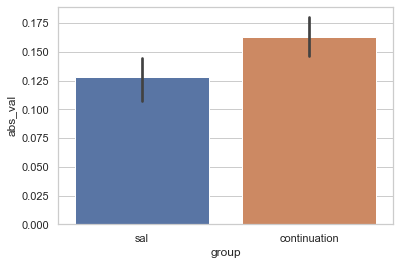

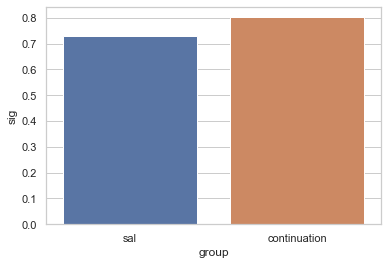

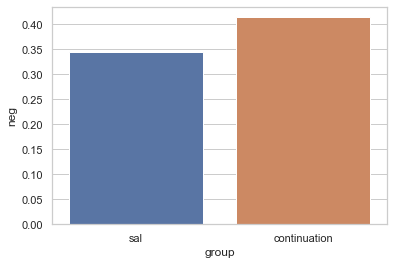

In [31]:
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

def plot_comb(df, comb):
    df1 = df.loc[lambda x: x.comb == comb]
    plt.figure()
    sns.barplot(data=df1, x="group", y="abs_val", estimator=np.median)
    plt.savefig(f"corr_mag_{comb}.svg")

    plt.figure()
    sns.barplot(data=df1.assign(sig=lambda x: x.p < 0.05), x="group", y="sig", ci=None)
    plt.savefig(f"pct_sig_{comb}.svg")

    plt.figure()
    sns.barplot(data=df1.loc[lambda x: x.p < 0.05].assign(neg=lambda x: x.value < 0), x="group", y="neg", ci=None)
    plt.savefig(f"neg_{comb}.svg")

plot_comb(df, "slow_regular-slow_regular")

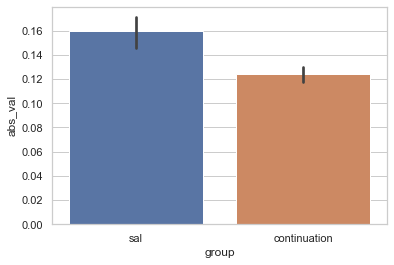

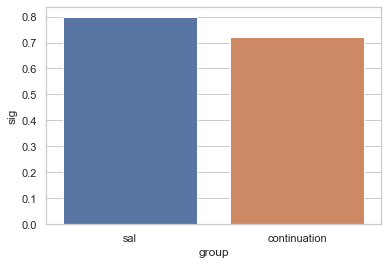

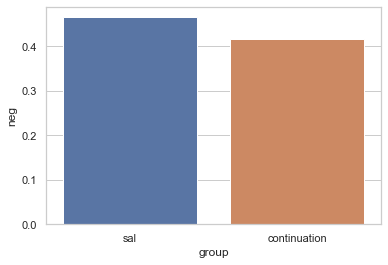

In [32]:
plot_comb(df, "slow_irregular-slow_regular")

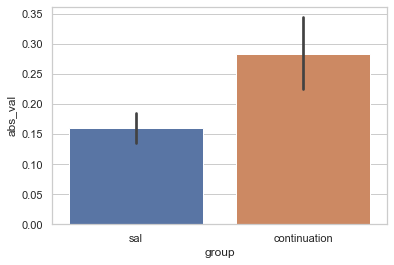

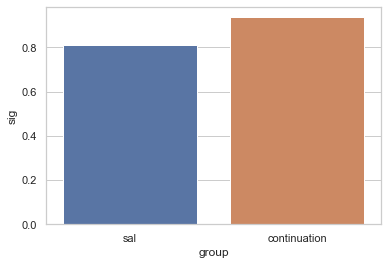

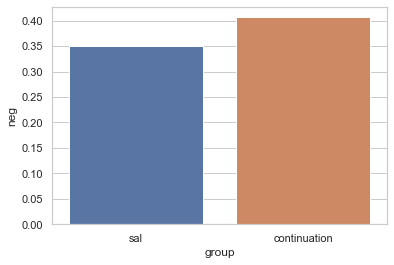

In [33]:
plot_comb(df, "slow_regular-fast_firing")

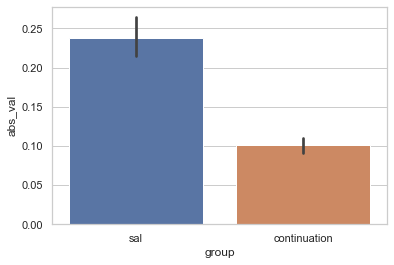

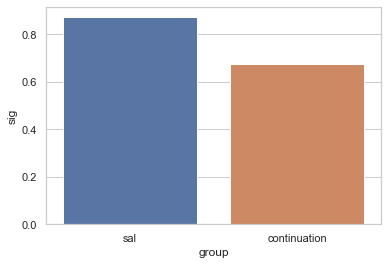

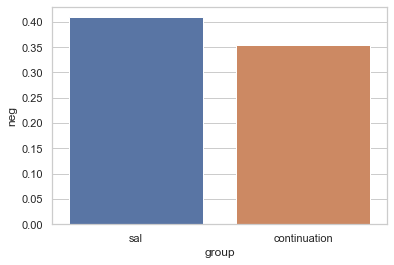

In [34]:
plot_comb(df, "slow_irregular-slow_irregular")

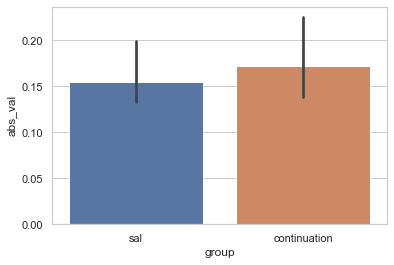

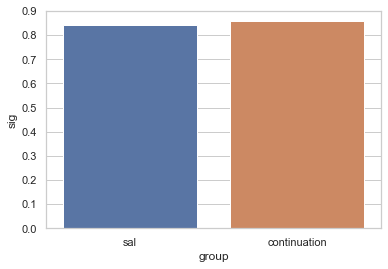

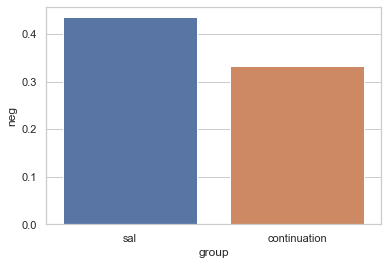

In [35]:
plot_comb(df, "slow_irregular-fast_firing")

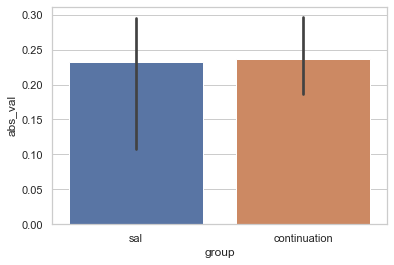

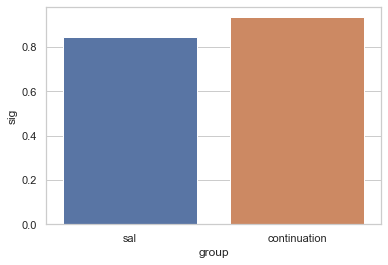

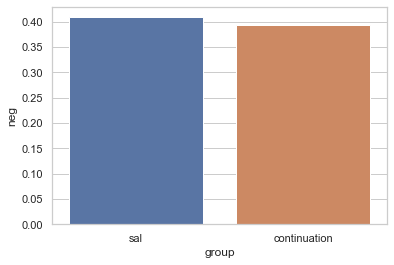

In [36]:
plot_comb(df, "fast_firing-fast_firing")

<AxesSubplot:xlabel='comb', ylabel='value'>

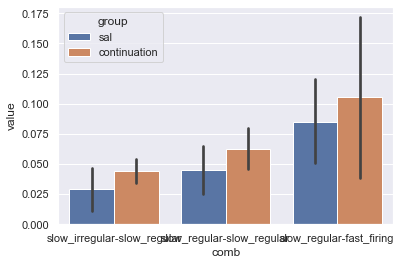

In [18]:
sns.barplot(data=df.loc[lambda x: x.comb.str.contains("slow_regular")], hue="group", x="comb", y="value")

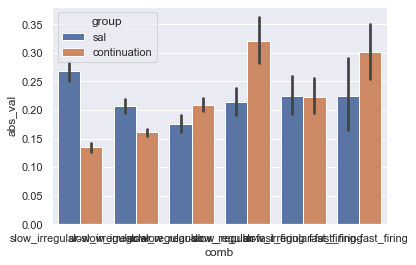

In [14]:
ax = sns.barplot(data=df, hue="group", x="comb", y="abs_val")


C:\Users\roryl\.conda\envs\ephys\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


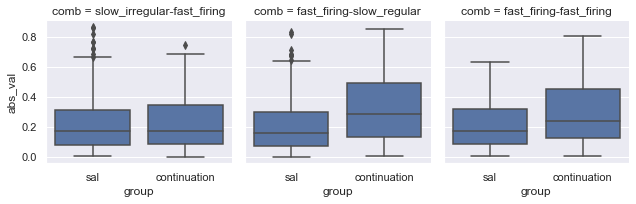

In [33]:
sns.FacetGrid(data=df, col="comb").map(sns.boxplot, "group", "abs_val")

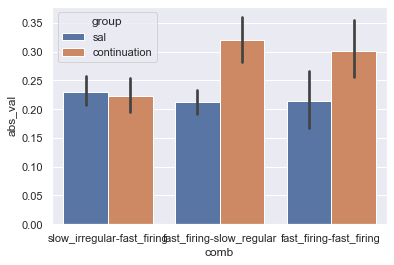

In [34]:
ax = sns.barplot(data=df, hue="group", x="comb", y="abs_val")
# ax.set_xticklabels(["SR-SIR", "SR-FF", "SR-SR"])

df

In [22]:
import statsmodels.formula.api as smf

# df1 = df.loc[lambda x: (x.comb == "slow_regular-slow_regular")]
# mod = smf.ols("abs_val ~ group", data=df1).fit()
# print(f"SR-SR {mod.conf_int().iloc[1, :].values}")

# df1 = df.loc[lambda x: (x.comb == "slow_irregular-slow_regular")]
# mod = smf.ols("abs_val ~ group", data=df1).fit()
# print(f"SR-SIR {mod.conf_int().iloc[1, :].values}")

df1 = df.loc[lambda x: (x.comb == "fast_firing-slow_regular")]
mod = smf.ols("abs_val ~ group", data=df1).fit()
print(f"SR-FF {mod.conf_int().iloc[1, :].values}")

SR-FF [-0.15006566 -0.06797219]


In [5]:
from spiketimes.utils import p_adjust

df_stats = pd.read_parquet(get_data_dir() / "derived" / "spont_ensemble_stats.parquet.gzip")
df = df_stats.merge(neurons[["session_name", "group"]].drop_duplicates()).assign(pval_sig=lambda x: p_adjust(x.score_pval) < 0.05).loc[lambda x: x.group.isin(["sal", "continuation"])]

df[["sig"]] = (df["pval_sig"]) & (df["simmilarity"] > 0.1)

ValueError: Columns must be same length as key

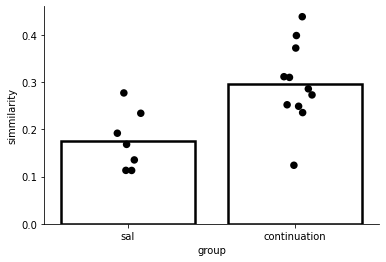

In [142]:
sns.barplot(data=df.loc[lambda x: x.sig == True], x="group", y="simmilarity", ci=None, edgecolor="black", fc="none", linewidth=2.5)
sns.stripplot(data=df.loc[lambda x: x.sig == True], x="group", y="simmilarity", color="black", linewidth=2.5)
sns.despine()

In [143]:
nums = df.loc[lambda x: x.simmilarity > 0.2].groupby("session_name", as_index=False).apply(lambda x: x.ensemble_id.nunique())
num_ensembles = df[["session_name", "group"]].drop_duplicates().merge(nums, how="left").fillna(0).rename(columns={None: "num_ensembles"})

mod = smf.ols("num_ensembles ~ group", data=num_ensembles).fit()
table = sm.stats.anova_lm(mod, typ=3)
table

,sum_sq,df,F,PR(>F)
Intercept,14.285714,1.0,27.272727,0.000547
group,2.194805,1.0,4.190083,0.070961
Residual,4.714286,9.0,NaN,NaN


In [145]:
df1 = df.loc[lambda x: x.sig == True]
pairwise_tukeyhsd(df1["simmilarity"], df1["group"]).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
continuation,sal,-0.1195,0.0063,-0.2001,-0.039,True


In [146]:
nums = df.loc[lambda x: x.sig == True].groupby("session_name", as_index=False).apply(lambda x: x.ensemble_id.nunique())

num_ensembles = df[["session_name", "group"]].drop_duplicates().merge(nums, how="left").fillna(0).rename(columns={None: "num_ensembles"})


mod = smf.ols("num_ensembles ~ group", data=num_ensembles).fit()
table = sm.stats.anova_lm(mod, typ=3)
table

,sum_sq,df,F,PR(>F)
Intercept,17.285714,1.0,24.066298,0.000841
group,0.081169,1.0,0.113009,0.744450
Residual,6.464286,9.0,NaN,NaN


In [149]:
num_ensembles

,session_name,group,num_ensembles
0,hamilton_01,sal,1
1,hamilton_02,continuation,1
2,hamilton_13,sal,1
3,hamilton_14,continuation,1
4,hamilton_23,continuation,1
5,hamilton_07,sal,3
6,hamilton_08,continuation,3
7,hamilton_19,sal,2
8,hamilton_20,continuation,2
9,chronic_08,continuation,1


In [151]:
num_ensembles = df[["session_name", "group"]].drop_duplicates()
num_ensembles

,session_name,group
0,hamilton_01,sal
2,hamilton_02,continuation
6,hamilton_13,sal
10,hamilton_14,continuation
20,hamilton_23,continuation
22,hamilton_07,sal
25,hamilton_08,continuation
29,hamilton_19,sal
31,hamilton_20,continuation
48,chronic_08,continuation


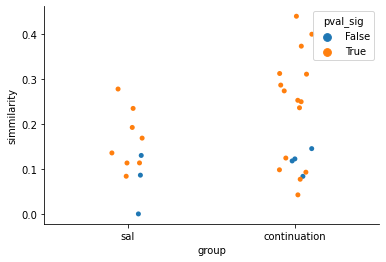

In [124]:
# df["score_sig"] =df["score_pval"] < 0.05

sns.stripplot(data=df, x="group", y="simmilarity", hue="pval_sig")
sns.despine()

In [ ]:

sns.barplot(data=prop, x="group", y="proportion", color="black")
sns.despine()


In [89]:
# relative proportion of ensembles?
# num ensembles / num recordings

num_recordings = neurons.groupby("group", as_index=False).apply(lambda x: x["session_name"].nunique()).rename(columns={None: "num_recordings"})
num_ensembles = df.loc[lambda x: x.pval_sig ==True].groupby("group", as_index=False).apply(lambda x: len(x)).rename(columns={None: "num_ensembles"})

prop = num_recordings.merge(num_ensembles)
prop["proportion"] = prop["num_ensembles"].divide(prop["num_recordings"])
prop

,group,num_recordings,num_ensembles,proportion
0,continuation,7,15,2.142857
1,discontinuation,9,13,1.444444
2,sal,5,8,1.600000


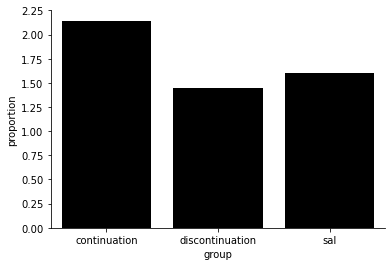

In [69]:
sns.barplot(data=prop, x="group", y="proportion", color="black")
sns.despine()


# model 

#   pval_sig ~ group
#   ensembles_in_session ~ group

In [42]:
df.loc[lambda x: x.pval_sig == True].groupby("group", as_index=False).apply(lambda x: x.simmilarity.mean())

,group,NaN
0,continuation,0.237588
1,discontinuation,0.148332
2,sal,0.164716


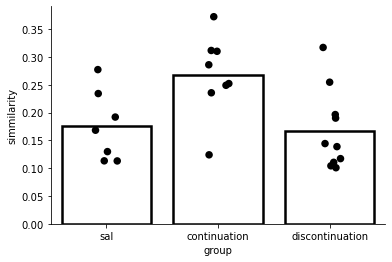

In [99]:

sns.barplot(data=df.loc[lambda x: x.ensemble_sig == True], x="group", y="simmilarity", ci=None, edgecolor="black", fc="none", linewidth=2.5)
sns.stripplot(data=df.loc[lambda x: x.ensemble_sig == True], x="group", y="simmilarity", color="black", linewidth=2.5)
sns.despine()



In [80]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd


mod = smf.ols("simmilarity ~ group", data=df.loc[lambda x: x.ensemble_sig == True]).fit()
table = sm.stats.anova_lm(mod, typ=3)
table

,sum_sq,df,F,PR(>F)
Intercept,0.573764,1.0,116.541348,2.946212e-10
group,0.051450,2.0,5.225162,1.390721e-02
Residual,0.108312,22.0,NaN,NaN


In [78]:
df1 = df.loc[lambda x: x.ensemble_sig == True]
pairwise_tukeyhsd(df1["simmilarity"], df1["group"]).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
continuation,discontinuation,-0.1003,0.0169,-0.1839,-0.0167,True
continuation,sal,-0.0923,0.0469,-0.1835,-0.0011,True
discontinuation,sal,0.008,0.9,-0.0789,0.0948,False


<AxesSubplot:xlabel='group', ylabel='simmilarity'>

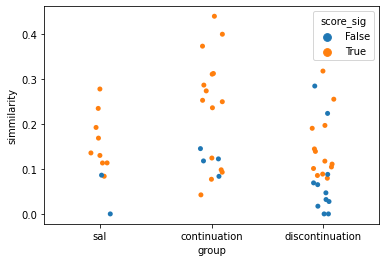

In [117]:
df["score_sig"] =df["score_pval"] < 0.05

sns.stripplot(data=df, x="group", y="simmilarity", hue="score_sig")

In [93]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd


mod = smf.ols("size ~ group", data=df.loc[lambda x: x.ensemble_sig == True]).fit()
table = sm.stats.anova_lm(mod, typ=3)
table

df1 = df.loc[lambda x: x.ensemble_sig == True]
pairwise_tukeyhsd(df1["size"], df1["group"]).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
continuation,discontinuation,-5.575,0.2281,-13.8162,2.6662,False
continuation,sal,3.3393,0.6198,-5.6526,12.3312,False
discontinuation,sal,8.9143,0.0403,0.3523,17.4763,True


<AxesSubplot:xlabel='group', ylabel='size'>

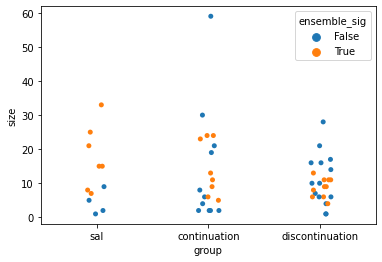

In [94]:
sns.stripplot(data=df, x="group", y="size", hue="ensemble_sig")

In [113]:


nums = df.loc[lambda x: x.simmilarity > 0.2].groupby("session_name", as_index=False).apply(lambda x: x.ensemble_id.nunique())

num_ensembles = neurons[["session_name", "group"]].drop_duplicates().merge(nums, how="left").fillna(0).rename(columns={None: "num_ensembles"})


mod = smf.ols("num_ensembles ~ group", data=num_ensembles).fit()
table = sm.stats.anova_lm(mod, typ=3)
table

,sum_sq,df,F,PR(>F)
Intercept,14.285714,1.0,28.144545,0.000048
group,4.673016,2.0,4.603197,0.024289
Residual,9.136508,18.0,NaN,NaN


<AxesSubplot:xlabel='group', ylabel='num_ensembles'>

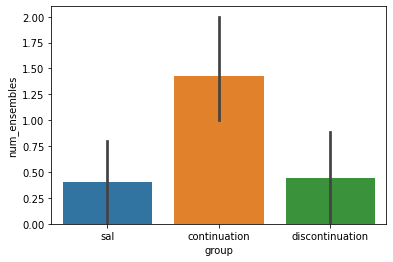

In [114]:
sns.barplot(x="group", y="num_ensembles", data=num_ensembles)